In [5]:
!pip install mne scipy matplotlib


In [172]:
from google.colab import files

uploaded = files.upload()


Saving 31.edf to 31.edf


In [174]:
print(f"Sampling frequency: {fs} Hz")


Sampling frequency: 260.0 Hz


Extracting EDF parameters from /content/31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86839  =      0.000 ...   333.996 secs...
Available channels: ['ECG_V4']
Sampling frequency: 260.0 Hz


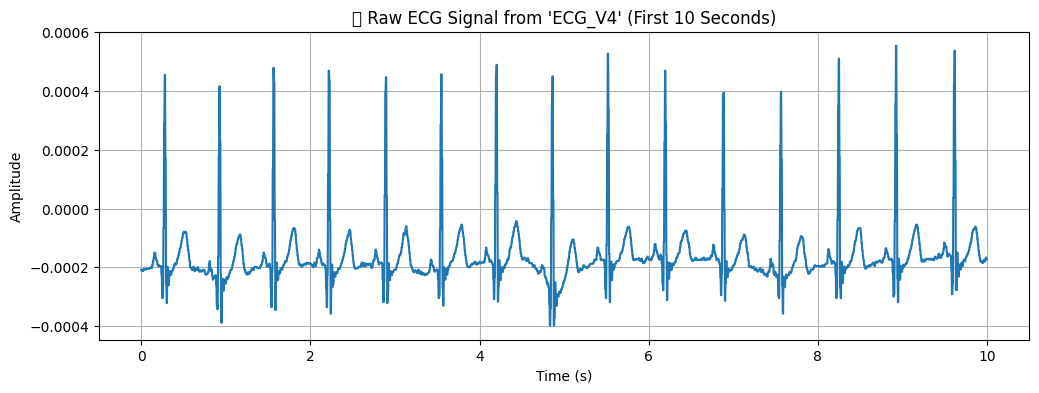

In [173]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the EDF file
raw = mne.io.read_raw_edf("/content/31.edf", preload=True)

# Print available channel names
print("Available channels:", raw.ch_names)

# Extract raw ECG signal from 'ECG_V4' channel
ecg_data, times = raw.get_data(picks='ECG_V4', return_times=True)
ecg_signal = ecg_data[0]  # Flatten it

# Get sampling frequency
fs = raw.info['sfreq']
print(f"Sampling frequency: {fs} Hz")

# Plot first 10 seconds of raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(times[:int(fs*10)], ecg_signal[:int(fs*10)])
plt.title("📉 Raw ECG Signal from 'ECG_V4' (First 10 Seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


Extracting EDF parameters from /content/31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86839  =      0.000 ...   333.996 secs...
Available channels: ['ECG_V4']
Sampling frequency: 260.0 Hz


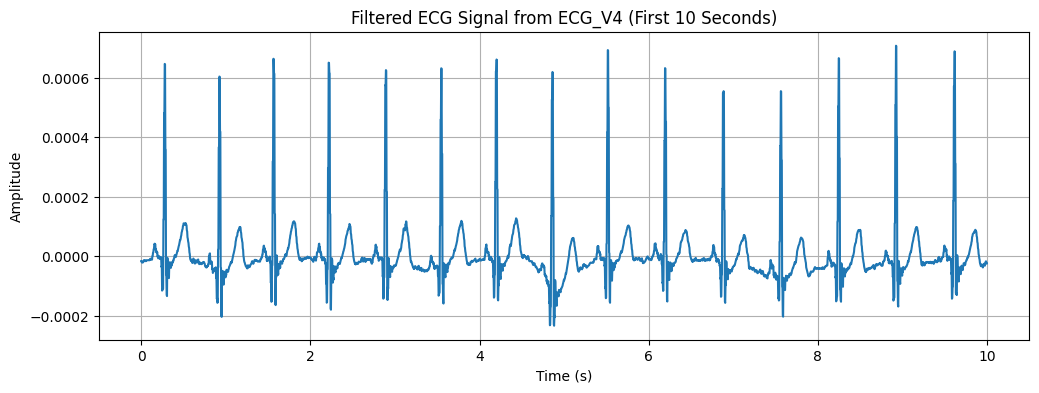

In [175]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Load the .edf file
raw = mne.io.read_raw_edf("/content/31.edf", preload=True)

# Check available channels
print("Available channels:", raw.ch_names)

# Use the correct ECG channel name
ecg_data, times = raw.get_data(picks='ECG_V4', return_times=True)
ecg_signal = ecg_data[0]  # Flatten the array

# Sampling frequency
fs = raw.info['sfreq']
print(f"Sampling frequency: {fs} Hz")

# Bandpass filter function
def bandpass_filter(signal, lowcut=0.05, highcut=125.0, fs=1000.0, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Apply the filter
filtered_ecg = bandpass_filter(ecg_signal, fs=fs)

# Plot first 10 seconds
plt.figure(figsize=(12, 4))
plt.plot(times[:int(fs*10)], filtered_ecg[:int(fs*10)])
plt.title("Filtered ECG Signal from ECG_V4 (First 10 Seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


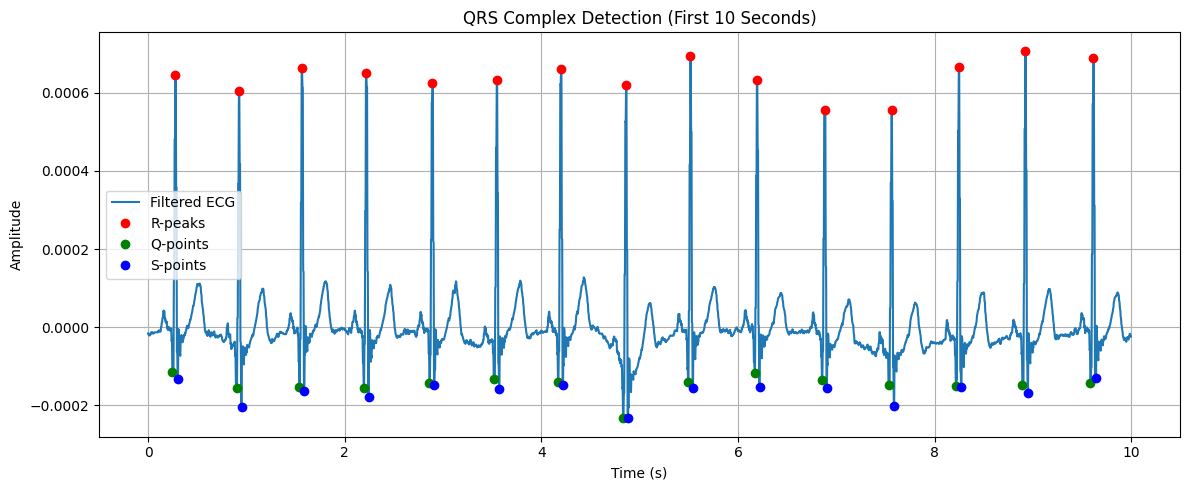

Sample QRS Complex Times:
Q: 0.246s, R: 0.277s, S: 0.304s
Q: 0.900s, R: 0.923s, S: 0.950s
Q: 1.538s, R: 1.562s, S: 1.588s


In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Step 1: Detect R-peaks
distance = int(0.6 * fs)  # ~60 BPM
height_thresh = np.std(filtered_ecg) * 1.0
r_peaks, _ = find_peaks(filtered_ecg, distance=distance, height=height_thresh)

# --- Step 2: Detect Q and S points
q_points = []
s_points = []
window_size = int(0.04 * fs)  # 40 ms window

for r in r_peaks:
    if r - window_size >= 0 and r + window_size < len(filtered_ecg):
        # Q-point
        q_region = filtered_ecg[r - window_size:r]
        q_index = np.argmin(q_region) + (r - window_size)
        q_points.append(q_index)

        # S-point
        s_region = filtered_ecg[r:r + window_size]
        s_index = np.argmin(s_region) + r
        s_points.append(s_index)

# --- Step 3: Plot within 10 seconds
max_index = int(fs * 10)
plt.figure(figsize=(12, 5))
plt.plot(times[:max_index], filtered_ecg[:max_index], label="Filtered ECG")

# Plot only points within the 10-second window
r_in_range = [i for i in r_peaks if i < max_index]
q_in_range = [i for i in q_points if i < max_index]
s_in_range = [i for i in s_points if i < max_index]

plt.plot(times[r_in_range], filtered_ecg[r_in_range], 'ro', label='R-peaks')
plt.plot(times[q_in_range], filtered_ecg[q_in_range], 'go', label='Q-points')
plt.plot(times[s_in_range], filtered_ecg[s_in_range], 'bo', label='S-points')

plt.title("QRS Complex Detection (First 10 Seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 4: Print first 3 QRS complex times (if available)
print("Sample QRS Complex Times:")
for i in range(min(3, len(q_points), len(r_peaks), len(s_points))):
    print(f"Q: {times[q_points[i]]:.3f}s, R: {times[r_peaks[i]]:.3f}s, S: {times[s_points[i]]:.3f}s")


Extracting EDF parameters from /content/31.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86839  =      0.000 ...   333.996 secs...

QRS Complexes (first 10):
Q: 0.246s, R: 0.277s, S: 0.304s
Q: 0.900s, R: 0.923s, S: 0.950s
Q: 1.538s, R: 1.562s, S: 1.588s
Q: 2.192s, R: 2.215s, S: 2.242s
Q: 2.862s, R: 2.892s, S: 2.912s
Q: 3.515s, R: 3.546s, S: 3.573s
Q: 4.169s, R: 4.200s, S: 4.219s
Q: 4.831s, R: 4.862s, S: 4.881s
Q: 5.492s, R: 5.515s, S: 5.542s
Q: 6.169s, R: 6.192s, S: 6.219s

RR Intervals (seconds):
RR 1-2: 0.646 s
RR 2-3: 0.638 s
RR 3-4: 0.654 s
RR 4-5: 0.677 s
RR 5-6: 0.654 s
RR 6-7: 0.654 s
RR 7-8: 0.662 s
RR 8-9: 0.654 s
RR 9-10: 0.677 s
RR 10-11: 0.692 s


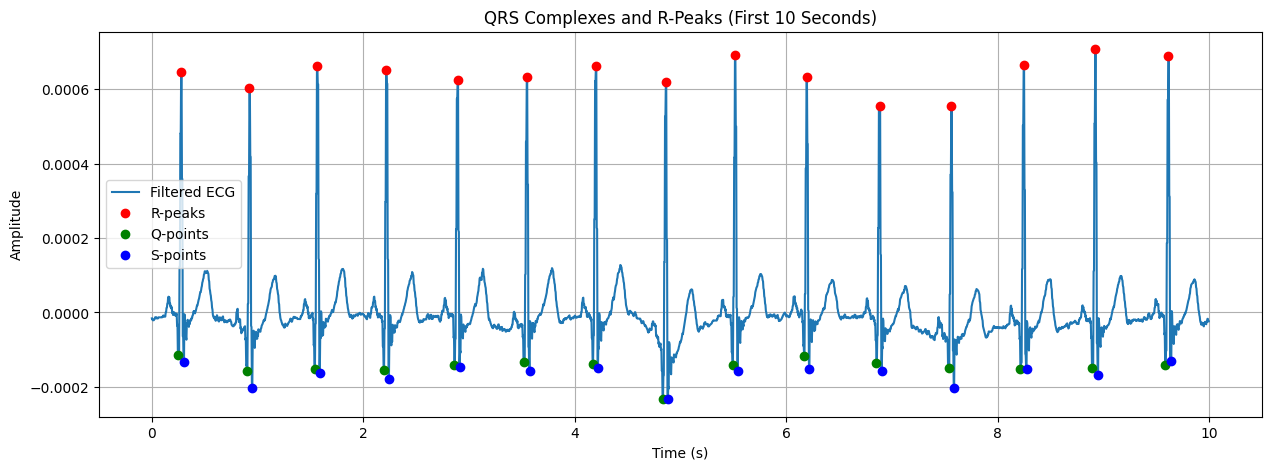

In [177]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import pandas as pd

# Load the .edf file
raw = mne.io.read_raw_edf("/content/31.edf", preload=True)

# Extract ECG
ecg_data, times = raw.get_data(picks='ECG_V4', return_times=True)
ecg_signal = ecg_data[0]
fs = raw.info['sfreq']

# Filter function
def bandpass_filter(signal, lowcut=0.05, highcut=125.0, fs=1000.0, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

filtered_ecg = bandpass_filter(ecg_signal, fs=fs)

# R-peak detection
min_distance = int(0.6 * fs)
r_peaks, _ = find_peaks(filtered_ecg, distance=min_distance, height=np.std(filtered_ecg))

# Initialize Q and S points
q_points = []
s_points = []

# Define window (±50ms) around R-peak to find Q and S
window = int(0.05 * fs)

for r in r_peaks:
    # Q-point
    start_q = max(r - window, 0)
    q_idx = start_q + np.argmin(filtered_ecg[start_q:r])
    q_points.append(q_idx)

    # S-point
    end_s = min(r + window, len(filtered_ecg) - 1)
    s_idx = r + np.argmin(filtered_ecg[r:end_s])
    s_points.append(s_idx)

# Compute RR intervals (in seconds)
rr_intervals = np.diff(times[r_peaks])

# Print QRS times and RR intervals
print("\nQRS Complexes (first 10):")
for i in range(min(10, len(r_peaks))):
    print(f"Q: {times[q_points[i]]:.3f}s, R: {times[r_peaks[i]]:.3f}s, S: {times[s_points[i]]:.3f}s")

print("\nRR Intervals (seconds):")
for i, rr in enumerate(rr_intervals[:10]):
    print(f"RR {i+1}-{i+2}: {rr:.3f} s")

# Optional: Save to CSV
qrs_data = pd.DataFrame({
    'Q_time': times[q_points],
    'R_time': times[r_peaks],
    'S_time': times[s_points]
})

rr_data = pd.DataFrame({
    'RR_interval_s': rr_intervals
})

# qrs_data.to_csv("qrs_times.csv", index=False)
# rr_data.to_csv("rr_intervals.csv", index=False)

# Plot QRS and R-peaks (first 10s)
plt.figure(figsize=(15, 5))
plt.plot(times[:int(fs*10)], filtered_ecg[:int(fs*10)], label='Filtered ECG')
plt.plot(times[r_peaks[(times[r_peaks] < 10)]], filtered_ecg[r_peaks[(times[r_peaks] < 10)]], 'ro', label='R-peaks')
plt.plot(times[[q for q in q_points if times[q] < 10]], filtered_ecg[[q for q in q_points if times[q] < 10]], 'go', label='Q-points')
plt.plot(times[[s for s in s_points if times[s] < 10]], filtered_ecg[[s for s in s_points if times[s] < 10]], 'bo', label='S-points')
plt.title("QRS Complexes and R-Peaks (First 10 Seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [178]:
# --- Step 5: Calculate RR intervals and Heart Rate
rr_intervals = np.diff(times[r_peaks])  # in seconds

# Filter out unrealistically long/short intervals (optional but recommended)
rr_intervals = rr_intervals[(rr_intervals > 0.3) & (rr_intervals < 1.5)]  # 40–200 bpm range

# Compute statistics
if len(rr_intervals) > 0:
    avg_rr = np.mean(rr_intervals)
    heart_rate = 60 / avg_rr
    print(f"\nMean RR Interval: {avg_rr:.3f} s")
    print(f"Estimated Heart Rate: {heart_rate:.2f} bpm")
else:
    print("\nNo valid RR intervals found for heart rate estimation.")



Mean RR Interval: 0.660 s
Estimated Heart Rate: 90.94 bpm
